
# Casas Benites — Brasil · **Exemplo Base: 1 Nova Loja + 1 Distribuidora**
Este notebook entrega um **exemplo mínimo pronto** para a turma:
1) **Expansão**: escolhemos **1 nova loja** (`k=1`, K-Means ponderado por população).  
2) **Distribuição**: dimensionamos **1 CD** (`k=1`) para atender **lojas existentes + a nova loja**.

> Os alunos devem **estender** para **k = 2..5** (tanto para **novas lojas** quanto para **CDs**) seguindo os blocos “TODO” mais abaixo.


## Imports e utilitários

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Distância Haversine (km) para lat/lon em graus
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def nearest_city(centroid, df, exclude_existing=False):
    lat, lon = centroid
    dists = haversine(lat, lon, df['lat'].values, df['lon'].values)
    order = np.argsort(dists)
    if not exclude_existing:
        idx = int(order[0]); row = df.iloc[idx]
        return row['city'], row['state'], float(dists[order[0]])
    for idx in order:
        row = df.iloc[int(idx)]
        if not row.get('existing_store', False):
            return row['city'], row['state'], float(dists[int(idx)])
    idx = int(order[0]); row = df.iloc[idx]
    return row['city'], row['state'], float(dists[idx])

def cluster_distance_stats(X, labels, centroids):
    rows, d_all = [], []
    for i in range(len(centroids)):
        mask = labels == i
        pts = X[mask]
        dists = haversine(pts[:,0], pts[:,1], centroids[i,0], centroids[i,1])
        d_all.extend(list(dists))
        rows.append({
            "cluster": i+1,
            "n_points": int(mask.sum()),
            "avg_km": float(np.mean(dists)) if len(dists) else 0.0,
            "p90_km": float(np.percentile(dists, 90)) if len(dists) else 0.0,
            "max_km": float(np.max(dists)) if len(dists) else 0.0,
        })
    global_stats = {
        "global_avg_km": float(np.mean(d_all)) if len(d_all) else 0.0,
        "global_p90_km": float(np.percentile(d_all, 90)) if len(d_all) else 0.0,
        "global_max_km": float(np.max(d_all)) if len(d_all) else 0.0,
    }
    return pd.DataFrame(rows), global_stats



## Dados nacionais embutidos (capitais + polos)
`existing_store=True` indica cidades onde **já há loja**. As demais são **candidatas** à expansão.  
População está em **ordem de grandeza** para fins didáticos.


In [5]:

br_data = [
    {'city': 'São Paulo', 'state': 'SP', 'lat': -23.5505, 'lon': -46.6333, 'population': 12000000, 'existing_store': True},
    {'city': 'Campinas', 'state': 'SP', 'lat': -22.9056, 'lon': -47.0608, 'population': 1300000, 'existing_store': True},
    {'city': 'Ribeirão Preto', 'state': 'SP', 'lat': -21.1775, 'lon': -47.8103, 'population': 720000, 'existing_store': True},
    {'city': 'São José dos Campos', 'state': 'SP', 'lat': -23.1896, 'lon': -45.8841, 'population': 750000, 'existing_store': True},
    {'city': 'Santos', 'state': 'SP', 'lat': -23.959, 'lon': -46.3336, 'population': 430000, 'existing_store': True},
    {'city': 'Rio de Janeiro', 'state': 'RJ', 'lat': -22.9068, 'lon': -43.1729, 'population': 6700000, 'existing_store': True},
    {'city': 'Niterói', 'state': 'RJ', 'lat': -22.8859, 'lon': -43.1153, 'population': 500000, 'existing_store': False},
    {'city': 'Belo Horizonte', 'state': 'MG', 'lat': -19.9167, 'lon': -43.9345, 'population': 2500000, 'existing_store': True},
    {'city': 'Uberlândia', 'state': 'MG', 'lat': -18.9186, 'lon': -48.2772, 'population': 700000, 'existing_store': False},
    {'city': 'Juiz de Fora', 'state': 'MG', 'lat': -21.7606, 'lon': -43.3434, 'population': 580000, 'existing_store': False},
    {'city': 'Vitória', 'state': 'ES', 'lat': -20.3155, 'lon': -40.3128, 'population': 365000, 'existing_store': True},
    {'city': 'Serra', 'state': 'ES', 'lat': -20.1211, 'lon': -40.3074, 'population': 520000, 'existing_store': False},
    {'city': 'Curitiba', 'state': 'PR', 'lat': -25.4284, 'lon': -49.2733, 'population': 1900000, 'existing_store': True},
    {'city': 'Londrina', 'state': 'PR', 'lat': -23.3045, 'lon': -51.1696, 'population': 580000, 'existing_store': False},
    {'city': 'Maringá', 'state': 'PR', 'lat': -23.42, 'lon': -51.9331, 'population': 430000, 'existing_store': False},
    {'city': 'Porto Alegre', 'state': 'RS', 'lat': -30.0346, 'lon': -51.2177, 'population': 1500000, 'existing_store': True},
    {'city': 'Caxias do Sul', 'state': 'RS', 'lat': -29.1678, 'lon': -51.1794, 'population': 520000, 'existing_store': False},
    {'city': 'Florianópolis', 'state': 'SC', 'lat': -27.5949, 'lon': -48.5482, 'population': 550000, 'existing_store': True},
    {'city': 'Joinville', 'state': 'SC', 'lat': -26.3044, 'lon': -48.8477, 'population': 610000, 'existing_store': False},
    {'city': 'Blumenau', 'state': 'SC', 'lat': -26.9155, 'lon': -49.0709, 'population': 360000, 'existing_store': False},
    {'city': 'Brasília', 'state': 'DF', 'lat': -15.7939, 'lon': -47.8828, 'population': 3000000, 'existing_store': True},
    {'city': 'Goiânia', 'state': 'GO', 'lat': -16.6869, 'lon': -49.2648, 'population': 1600000, 'existing_store': True},
    {'city': 'Anápolis', 'state': 'GO', 'lat': -16.3281, 'lon': -48.953, 'population': 400000, 'existing_store': False},
    {'city': 'Campo Grande', 'state': 'MS', 'lat': -20.4697, 'lon': -54.6201, 'population': 930000, 'existing_store': True},
    {'city': 'Cuiabá', 'state': 'MT', 'lat': -15.601, 'lon': -56.0974, 'population': 630000, 'existing_store': True},
    {'city': 'Rondonópolis', 'state': 'MT', 'lat': -16.4673, 'lon': -54.6372, 'population': 250000, 'existing_store': False},
    {'city': 'Salvador', 'state': 'BA', 'lat': -12.9777, 'lon': -38.5016, 'population': 2900000, 'existing_store': True},
    {'city': 'Feira de Santana', 'state': 'BA', 'lat': -12.2546, 'lon': -38.9647, 'population': 620000, 'existing_store': False},
    {'city': 'Vitória da Conquista', 'state': 'BA', 'lat': -14.8619, 'lon': -40.8442, 'population': 340000, 'existing_store': False},
    {'city': 'Fortaleza', 'state': 'CE', 'lat': -3.7319, 'lon': -38.5267, 'population': 2700000, 'existing_store': True},
    {'city': 'Sobral', 'state': 'CE', 'lat': -3.6891, 'lon': -40.3482, 'population': 210000, 'existing_store': False},
    {'city': 'Juazeiro do Norte', 'state': 'CE', 'lat': -7.1967, 'lon': -39.3075, 'population': 280000, 'existing_store': False},
    {'city': 'Recife', 'state': 'PE', 'lat': -8.0476, 'lon': -34.877, 'population': 1600000, 'existing_store': True},
    {'city': 'Caruaru', 'state': 'PE', 'lat': -8.2845, 'lon': -35.9699, 'population': 370000, 'existing_store': False},
    {'city': 'João Pessoa', 'state': 'PB', 'lat': -7.1153, 'lon': -34.861, 'population': 830000, 'existing_store': True},
    {'city': 'Natal', 'state': 'RN', 'lat': -5.7945, 'lon': -35.211, 'population': 900000, 'existing_store': True},
    {'city': 'Maceió', 'state': 'AL', 'lat': -9.6498, 'lon': -35.7089, 'population': 1000000, 'existing_store': True},
    {'city': 'Aracaju', 'state': 'SE', 'lat': -10.9472, 'lon': -37.0731, 'population': 670000, 'existing_store': True},
    {'city': 'Teresina', 'state': 'PI', 'lat': -5.0919, 'lon': -42.8034, 'population': 870000, 'existing_store': True},
    {'city': 'São Luís', 'state': 'MA', 'lat': -2.5387, 'lon': -44.2825, 'population': 1100000, 'existing_store': True},
    {'city': 'Manaus', 'state': 'AM', 'lat': -3.1019, 'lon': -60.025, 'population': 2200000, 'existing_store': True},
    {'city': 'Boa Vista', 'state': 'RR', 'lat': 2.8235, 'lon': -60.6758, 'population': 420000, 'existing_store': False},
    {'city': 'Rio Branco', 'state': 'AC', 'lat': -9.9747, 'lon': -67.8106, 'population': 420000, 'existing_store': True},
    {'city': 'Porto Velho', 'state': 'RO', 'lat': -8.7608, 'lon': -63.9039, 'population': 550000, 'existing_store': True},
    {'city': 'Macapá', 'state': 'AP', 'lat': 0.0356, 'lon': -51.0705, 'population': 520000, 'existing_store': True},
    {'city': 'Belém', 'state': 'PA', 'lat': -1.4558, 'lon': -48.4902, 'population': 1500000, 'existing_store': True},
    {'city': 'Santarém', 'state': 'PA', 'lat': -2.4385, 'lon': -54.6996, 'population': 310000, 'existing_store': False},
    {'city': 'Marabá', 'state': 'PA', 'lat': -5.3686, 'lon': -49.1178, 'population': 280000, 'existing_store': False},
    {'city': 'Palmas', 'state': 'TO', 'lat': -10.1844, 'lon': -48.3336, 'population': 320000, 'existing_store': True},
    {'city': 'Araguaína', 'state': 'TO', 'lat': -7.192, 'lon': -48.2045, 'population': 190000, 'existing_store': False}
]

df = pd.DataFrame(br_data)
df_existing = df[df['existing_store']].copy()
print("Total de cidades:", len(df), "| Lojas existentes:", len(df_existing))
df.head()


Total de cidades: 50 | Lojas existentes: 30


,city,state,lat,lon,population,existing_store
0,São Paulo,SP,-23.5505,-46.6333,12000000,True
1,Campinas,SP,-22.9056,-47.0608,1300000,True
2,Ribeirão Preto,SP,-21.1775,-47.8103,720000,True
3,São José dos Campos,SP,-23.1896,-45.8841,750000,True
4,Santos,SP,-23.9590,-46.3336,430000,True


## Visualização: lojas existentes (quadrados) e demais cidades (pontos)

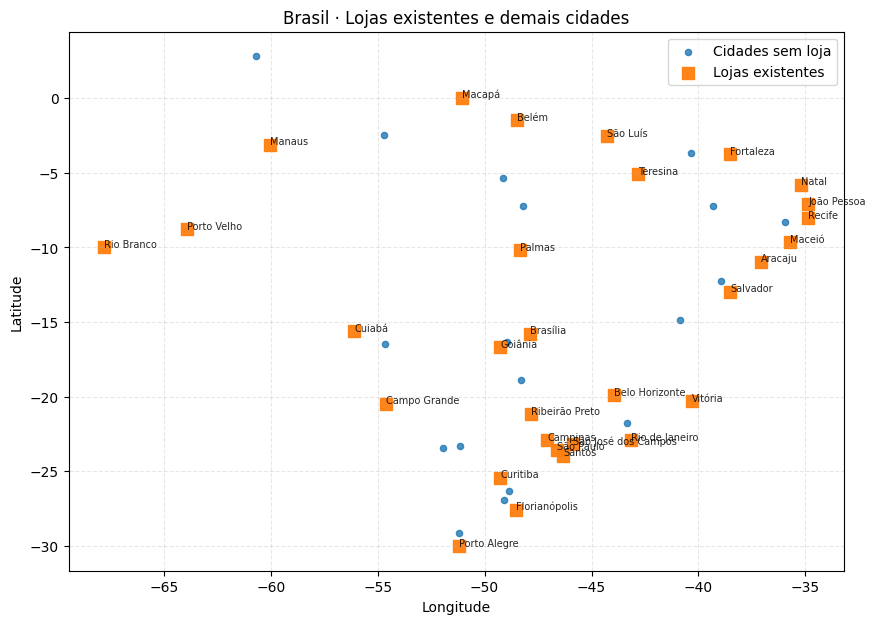

In [6]:

plt.figure(figsize=(10,7))
mask = df['existing_store']
plt.scatter(df.loc[~mask,'lon'], df.loc[~mask,'lat'], s=20, alpha=0.8, label="Cidades sem loja")
plt.scatter(df.loc[mask,'lon'], df.loc[mask,'lat'], s=65, alpha=0.95, marker='s', label="Lojas existentes")
for _, row in df.iterrows():
    if row['existing_store']:
        plt.annotate(row['city'], (row['lon'], row['lat']), fontsize=7, alpha=0.85)
plt.title("Brasil · Lojas existentes e demais cidades")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
plt.show()



# Parte 1 — **Expansão (k = 1)** — PRONTO
Rodamos **K-Means ponderado por população** com **k = 1** e sugerimos a **cidade sem loja** mais próxima do centróide como **nova loja**.


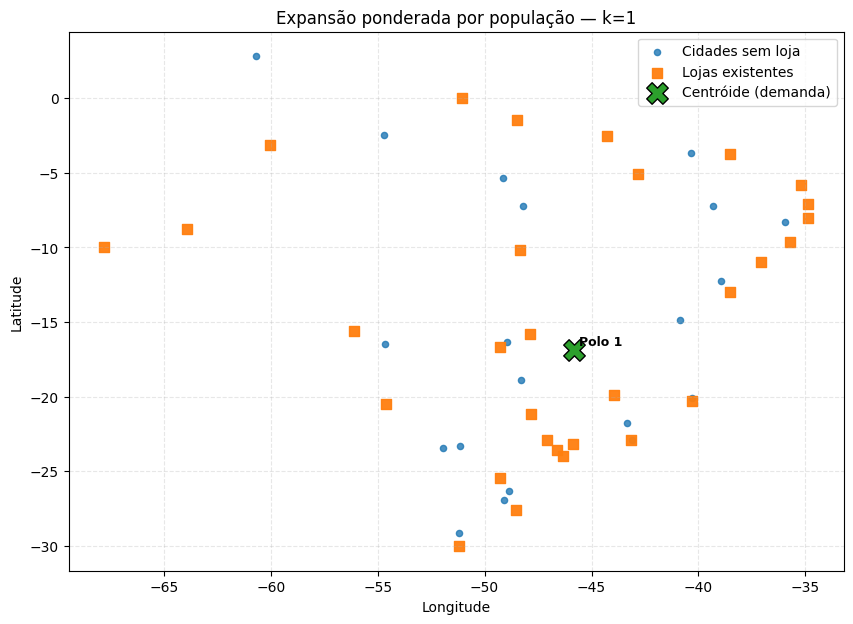

,k,cluster,cidade_candidata_nova_loja,estado,dist_km_centroid_to_city,centroid_lat,centroid_lon
0,1,1,Anápolis,GO,338.92044,-16.907163,-45.830049


Nova loja escolhida (k=1): {'cluster': 1, 'cidade': 'Anápolis', 'estado': 'GO'}


In [7]:

def run_weighted_expansion_k(df_full, k, random_state=42):
    X = df_full[['lat','lon']].values
    w = df_full['population'].values.astype(float)
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    labels = km.fit_predict(X, sample_weight=w)
    centroids = km.cluster_centers_
    sil = silhouette_score(X, labels) if k > 1 and k < len(X) else float('nan')

    plt.figure(figsize=(10,7))
    mask = df_full['existing_store']
    plt.scatter(df_full.loc[~mask,'lon'], df_full.loc[~mask,'lat'], s=20, alpha=0.8, label="Cidades sem loja")
    plt.scatter(df_full.loc[mask,'lon'], df_full.loc[mask,'lat'], s=60, alpha=0.95, marker='s', label="Lojas existentes")
    plt.scatter(centroids[:,1], centroids[:,0], s=240, marker='X', edgecolor='black', linewidth=1, label="Centróide (demanda)")
    for i in range(k):
        plt.annotate(f"Polo {i+1}", (centroids[i,1], centroids[i,0]), fontsize=9, fontweight='bold', xytext=(4,4), textcoords='offset points')
    plt.title(f"Expansão ponderada por população — k={k}")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
    plt.show()

    # Sugestões (preferindo não existentes)
    recs = []
    for i, c in enumerate(centroids, start=1):
        cidade, estado, dist_km = nearest_city(c, df_full, exclude_existing=True)
        recs.append({"k": k, "cluster": i, "cidade_candidata_nova_loja": cidade, "estado": estado,
                     "dist_km_centroid_to_city": dist_km, "centroid_lat": c[0], "centroid_lon": c[1]})
    return pd.DataFrame(recs)

# Executa k=1 e fixa a NOVA LOJA escolhida automaticamente
exp_k1_recs = run_weighted_expansion_k(df, k=1)
display(exp_k1_recs)

nova_loja_k1 = {
    "cluster": int(exp_k1_recs.iloc[0]["cluster"]),
    "cidade":  str(exp_k1_recs.iloc[0]["cidade_candidata_nova_loja"]),
    "estado":  str(exp_k1_recs.iloc[0]["estado"]),
}
print("Nova loja escolhida (k=1):", nova_loja_k1)



# Parte 2 — **CD (k = 1)** — PRONTO
Com a rede **pós-expansão** (lojas existentes + a nova loja acima), rodamos **K-Means** com **k = 1** para definir o **CD** e mapeamos o centróide para a **cidade real mais próxima**.


In [8]:

# Monta base pós-expansão (inclui a nova loja k=1)
df_post = df.copy()

# marca a cidade escolhida como loja ativa (se já existia na base, apenas garante o flag)
mask_city = (df_post['city']==nova_loja_k1['cidade']) & (df_post['state']==nova_loja_k1['estado'])
if mask_city.any():
    df_post.loc[mask_city, 'existing_store'] = True
else:
    # Caso extremo: se a cidade escolhida não estivesse na base (não deve ocorrer), adiciona
    df_post.loc[len(df_post)] = {
        "city": nova_loja_k1['cidade'], "state": nova_loja_k1['estado'],
        "lat": np.nan, "lon": np.nan, "population": 200000, "existing_store": True
    }

df_lojas_ativas = df_post[df_post['existing_store']].copy()
print("Total de lojas ativas (após expansão k=1):", len(df_lojas_ativas))
df_lojas_ativas[['city','state']].drop_duplicates().reset_index(drop=True).head(10)


Total de lojas ativas (após expansão k=1): 31


,city,state
0,São Paulo,SP
1,Campinas,SP
2,Ribeirão Preto,SP
3,São José dos Campos,SP
4,Santos,SP
5,Rio de Janeiro,RJ
6,Belo Horizonte,MG
7,Vitória,ES
8,Curitiba,PR
9,Porto Alegre,RS


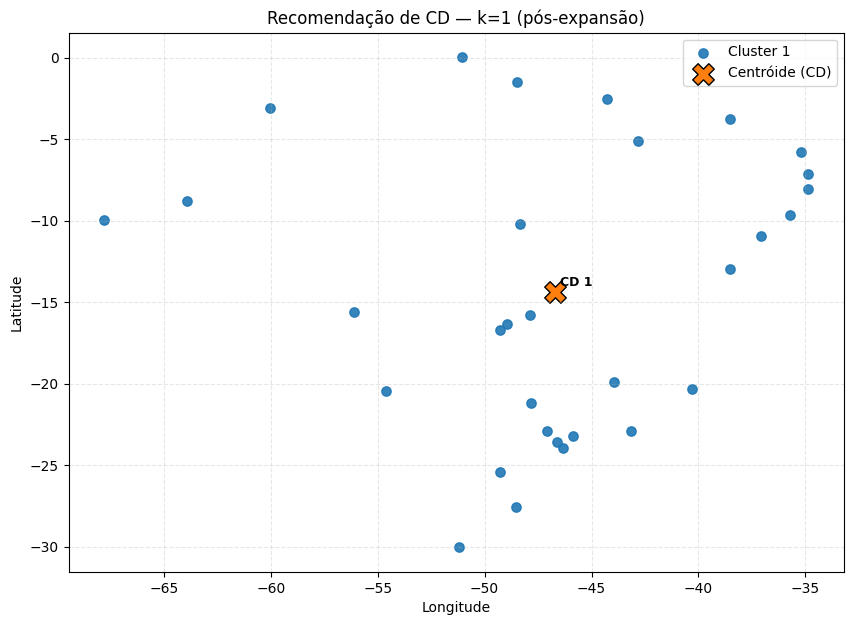

,k,cluster,cidade_candidata_CD,estado,dist_km_centroid_to_city,centroid_lat,centroid_lon
0,1,1,Brasília,DF,202.064998,-14.361139,-46.725116


CD sugerido (k=1): {'k': np.int64(1), 'cluster': np.int64(1), 'cidade_candidata_CD': 'Brasília', 'estado': 'DF', 'dist_km_centroid_to_city': np.float64(202.06499831885898), 'centroid_lat': np.float64(-14.36113870967742), 'centroid_lon': np.float64(-46.72511612903226)}


In [9]:

def run_cd_k(df_lojas, k, random_state=42):
    X = df_lojas[['lat','lon']].values
    km = KMeans(n_clusters=k, n_init='auto', random_state=random_state)
    labels = km.fit_predict(X)
    centroids = km.cluster_centers_

    # Plot
    plt.figure(figsize=(10,7))
    for i in range(k):
        pts = X[labels == i]
        plt.scatter(pts[:,1], pts[:,0], s=45, alpha=0.9, label=f"Cluster {i+1}")
    plt.scatter(centroids[:,1], centroids[:,0], s=240, marker='X', edgecolor='black', linewidth=1, label="Centróide (CD)")
    for i in range(k):
        plt.annotate(f"CD {i+1}", (centroids[i,1], centroids[i,0]), fontsize=9, fontweight='bold', xytext=(4,4), textcoords='offset points')
    plt.title(f"Recomendação de CD — k={k} (pós-expansão)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.3); plt.legend()
    plt.show()

    # Recomendações (cidade mais próxima do centróide)
    recs = []
    for i, c in enumerate(centroids, start=1):
        cidade, estado, dist_km = nearest_city(c, df, exclude_existing=False)
        recs.append({"k": k, "cluster": i, "cidade_candidata_CD": cidade, "estado": estado,
                     "dist_km_centroid_to_city": dist_km, "centroid_lat": c[0], "centroid_lon": c[1]})
    recs_df = pd.DataFrame(recs)
    return recs_df

cd_k1_recs = run_cd_k(df_lojas_ativas, k=1)
display(cd_k1_recs)
print("CD sugerido (k=1):", dict(cd_k1_recs.iloc[0]))



---
# ✅ Tarefa dos alunos — **Expansão (k = 2..5)**
1. Execute `run_weighted_expansion_k(df, k)` para k = 2..5.  
2. Escolha **exatamente k cidades sem loja** (uma por cluster) e liste-as na variável `novas_lojas`.  
3. **Reconstrua** a base pós-expansão e **avance** para a parte de CDs (k = 2..5).


### k = 2 (duas novas lojas)

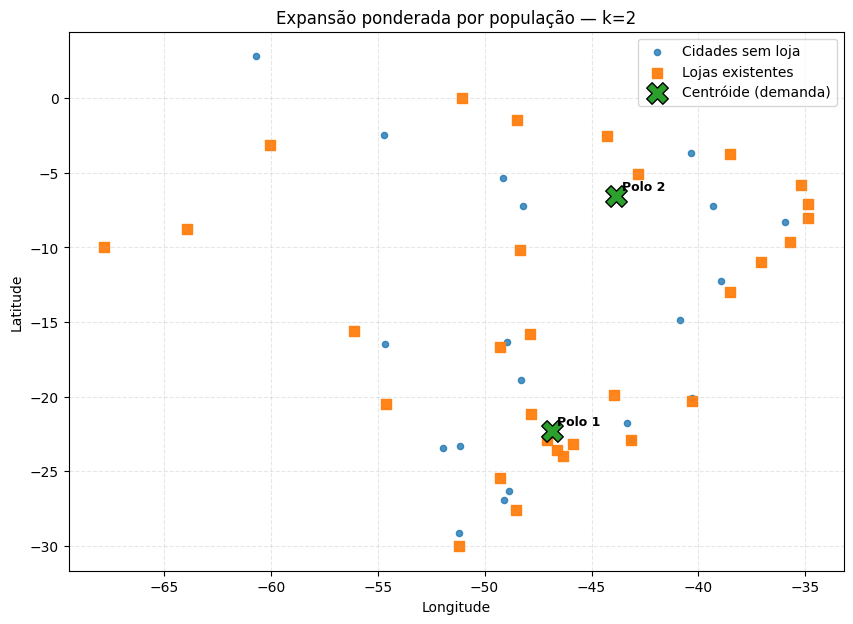

In [ ]:
cB2 = run_weighted_expansion_k(df, k=2)

### k = 3 (três novas lojas)

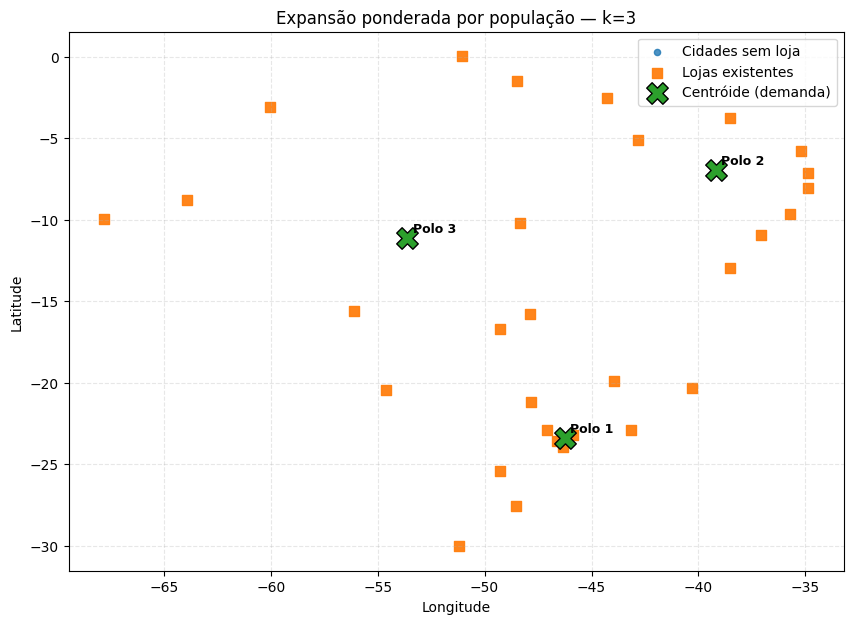

In [ ]:
cB3 = run_weighted_expansion_k(df, k=3)

### k = 4 (quatro novas lojas)

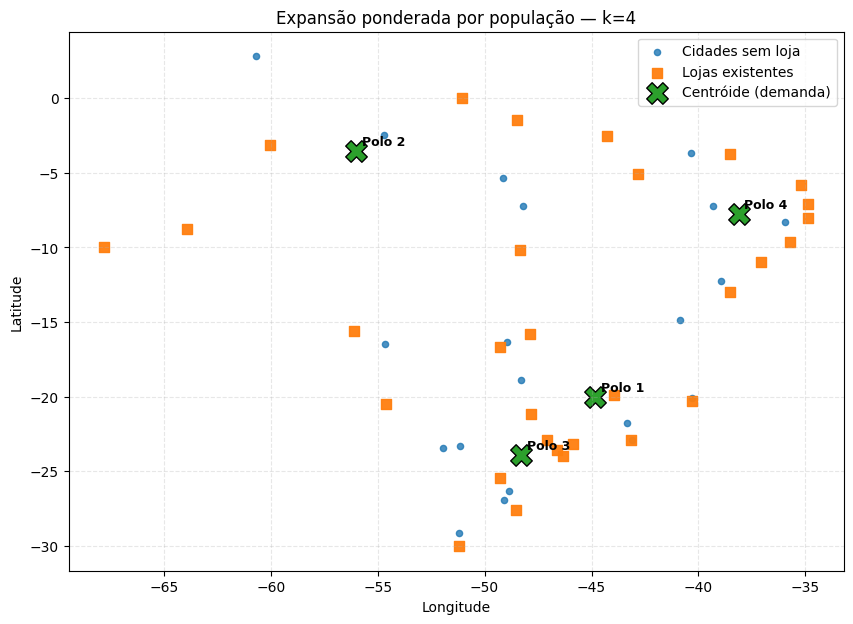

In [ ]:
cB4 = run_weighted_expansion_k(df, k=4)

### k = 5 (cinco novas lojas)

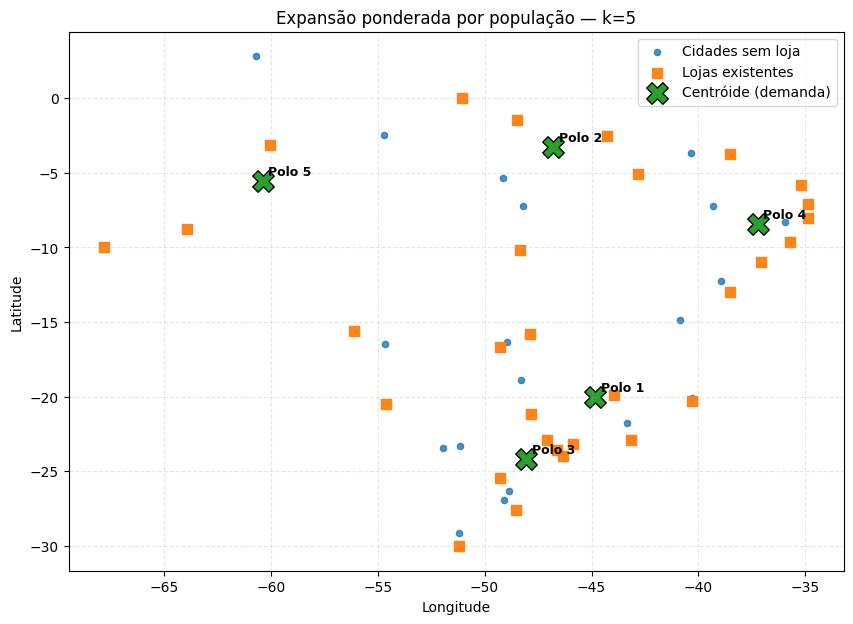

In [ ]:
cB5 = run_weighted_expansion_k(df, k=5)

In [ ]:

# Exemplo de execução (o aluno pode repetir e comparar k=2..5)
# _ = run_weighted_expansion_k(df, k=2)
# _ = run_weighted_expansion_k(df, k=3)
# ...

# ====== Preencha para o k escolhido (ex.: 3) ======
k_exp_escolhido = None  # ex.: 3
novas_lojas = [
    # {"cluster": 1, "cidade": "Feira de Santana", "estado": "BA"},
    # {"cluster": 2, "cidade": "Joinville", "estado": "SC"},
    # {"cluster": 3, "cidade": "Anápolis", "estado": "GO"},
]

if k_exp_escolhido is not None and len(novas_lojas) != k_exp_escolhido:
    print(f"Aviso: você escolheu k={k_exp_escolhido}, mas listou {len(novas_lojas)} novas lojas.")
pd.DataFrame(novas_lojas)


""



# ✅ Tarefa dos alunos — **CDs (k = 2..5)**
1. **Monte** a base pós-expansão com suas `novas_lojas`.  
2. Rode `run_cd_k(df_lojas_ativas, k)` para k = 2..5.  
3. Registre o **k** e a **lista de cidades candidatas a CD** no seu relatório.


In [ ]:

# Monta base pós-expansão com as suas escolhas (aluno)
df_post_aluno = df.copy()
if novas_lojas:
    for d in novas_lojas:
        mask = (df_post_aluno['city']==d['cidade']) & (df_post_aluno['state']==d['estado'])
        if mask.any():
            df_post_aluno.loc[mask, 'existing_store'] = True
        else:
            print("⚠️ Cidade escolhida não está na base, adicione lat/lon/population manualmente!")

df_lojas_ativas_aluno = df_post_aluno[df_post_aluno['existing_store']].copy()
print("Total de lojas ativas (após sua expansão):", len(df_lojas_ativas_aluno))

# Ex.: k=3
# recs_cds_k3 = run_cd_k(df_lojas_ativas_aluno, k=3)
# display(recs_cds_k3)


### k = 2 (dois CDs)

### k = 3 (três CDs)

### k = 4 (quatro CDs)

### k = 5 (cinco CDs)


## Entrega — Resumo do seu plano
Preencha com suas decisões finais quando concluir as tarefas (k de expansão e k de CDs).
